In [1]:
'''
here we'll act like we have a trained weights file, visualize the latent space, make reconstructions, and visualizations of all of those
'''
import numpy as np
import torch
import torch.optim as optim
import my_utils
import models
import utils
import matplotlib.pyplot as plt
import sklearn
from sklearn.manifold import TSNE

In [2]:
%load_ext autoreload

In [3]:
%autoreload

In [4]:
# load a trained checkpoint 

data_obj = my_utils.get_synthetic_data(seed=0, uniform=True)

net,optimizer, args, epoch, loss =  my_utils.load_checkpoint('synth_8246117.h5', data_obj)
    


(100, 1, 200, 6)
(80, 1, 200, 6) (10, 1, 200, 6) (10, 1, 200, 6)
=> loading checkpoint 'synth_8246117.h5'
Namespace(batch_size=8, niters=100, bound_variance=False, const_var=False, dropout=0.0, elbo_weight=4.1, embed_time=32, enc_num_heads=4, intensity=True, k_iwae=1, kl_annealing=True, kl_zero=False, latent_dim=32, lr=0.0005241352187508085, mixing='concat', mse_weight=4.0, net='hetvae', norm=True, normalize_input='znorm', num_ref_points=32, rec_hidden=32, recon_loss=False, sample_tp=0.5, save=True, seed=0, shuffle=True, std=0.1, var_per_dim=False, width=512, device='mps', data_obj='', checkpoint='', early_stopping=False, patience=50, save_at=50, scheduler=True, warmup=4000)
1


(2, 80, 200, 1) (2, 80, 200, 1) (80, 1, 200) (80, 1, 200) (80, 200)
(80, 200, 1) (80, 200, 1)


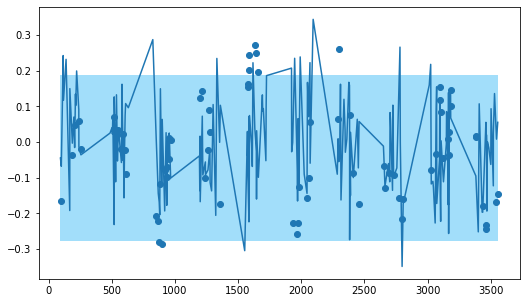

(80, 200, 1) (80, 200, 1)


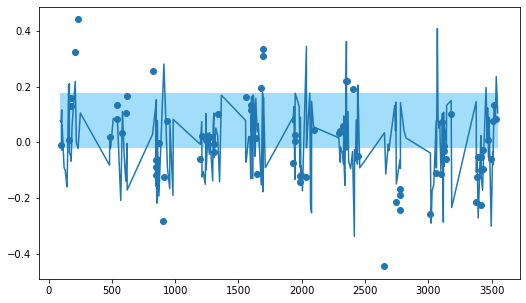

(80, 200, 1) (80, 200, 1)


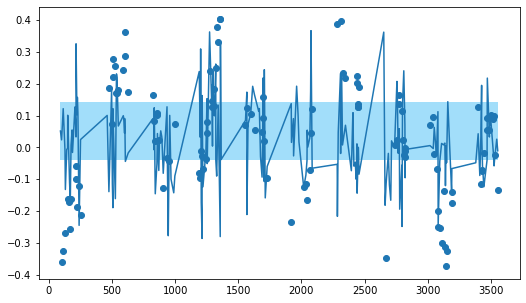

(80, 200, 1) (80, 200, 1)


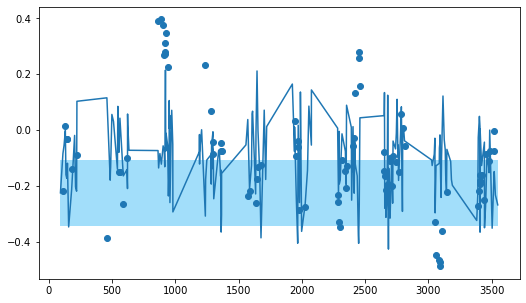

(80, 200, 1) (80, 200, 1)


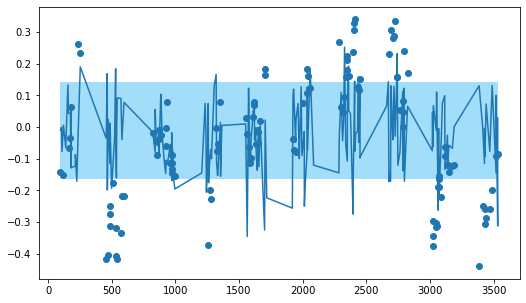

In [9]:
viz(data_obj['train_loader'])

In [8]:
def viz(dataloader, device='mps', k_iwae=2, n_max=5):
    pred_mean, pred_std = [], []
    masks = []
    targets = []
    tp =[]
    np.random.seed(0)
    with torch.no_grad():
        for batch in dataloader:
            batch_len = batch.shape[0]
            batch = batch.to(device)
            subsampled_mask = batch[:,:,:,4]
            recon_mask = batch[:,:,:,5]
            context_y = torch.cat((batch[:,:,:,1] * subsampled_mask, subsampled_mask), 1).transpose(2,1)
            # context_x = train_batch[:,0,:,0], where we'd set a target x
            #print(batch[:, 0, :,0].shape)
            px, qz = net.get_reconstruction(batch[:, 0, :,0], context_y, batch[:, 0, :,0], num_samples=k_iwae)
            pred_mean.append(px.mean.cpu().numpy())
            pred_std.append(torch.exp(0.5 * px.logvar).cpu().numpy())
            targets.append((batch[:, :, :,1]).cpu().numpy())
            masks.append(subsampled_mask.cpu().numpy())
            tp.append(batch[:, 0, :,0].cpu().numpy())
      
    pred_mean = np.concatenate(pred_mean, axis=1)
    pred_std = np.concatenate(pred_std, axis=1)
    targets = np.concatenate(targets, axis=0)
    masks = np.concatenate(masks, axis=0)
    tp = np.concatenate(tp, axis=0)
    print(pred_mean.shape, pred_std.shape, targets.shape, masks.shape, tp.shape)
    inputs = np.ma.masked_where(masks < 1., targets)
    inputs = np.transpose(inputs, [0,2,1])
    # reparam trick, add  random number to everything
    preds = np.random.randn(k_iwae//2, k_iwae, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3]) * pred_std + pred_mean
    preds = preds.reshape(-1, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3])
    median = preds.mean(0)
    pred_std = pred_std.mean(0)
#     median = preds.mean(0) #np.quantile(preds, 0.5, axis=0)
    quantile2 = np.quantile(preds, 0.841, axis=0)
    quantile1 = np.quantile(preds, 0.159, axis=0)
    
    
    for index in range(n_max):
        plt.figure(figsize=(50, 5))
        plt.subplot(1,n_max,index + 1)
        upto = 200 # np.argwhere(tp[index] == 0)[0,0]
        print(median.shape, quantile1.shape)
        plt.fill_between(tp[index, :upto], quantile1[index,0,:upto], quantile2[index,0,:upto], alpha=0.6, facecolor='#65c9f7', interpolate=True)
        #plt.fill_between(tp[index, :upto], median[index,0,:upto] - pred_std[index,0,:upto], median[index,0,:upto] + pred_std[index,0,:upto], alpha=0.6, facecolor='#65c9f7', interpolate=True)
        plt.plot(tp[index, :upto], median[index, :upto])
        plt.scatter(tp[index, :upto], inputs[index, :upto])
        plt.show()




In [61]:
# at some point, you wouldn't subsample at all? 

def get_latent_dist(dataloader, device='mps', k_iwae=2):
    qz_mean, qz_std = [], []
    np.random.seed(0)
    with torch.no_grad():
        for batch in dataloader:
            batch_len = batch.shape[0]
            batch = batch.to(device)
            subsampled_mask = batch[:,:,:,4]
            recon_mask = batch[:,:,:,5]
            context_y = torch.cat((batch[:,:,:,1] * subsampled_mask, subsampled_mask), 1).transpose(2,1)
            # context_x = train_batch[:,0,:,0], where we'd set a target x
            #print(batch[:, 0, :,0].shape)
            px, qz = net.get_reconstruction(batch[:, 0, :,0], context_y, batch[:, 0, :,0], num_samples=k_iwae)
            qz_mean.append(qz.mean.cpu().numpy())
            qz_std.append(torch.exp(0.5 * qz.logvar).cpu().numpy())
   
    qz_mean = np.concatenate(qz_mean, axis=0)
    qz_std = np.concatenate(qz_std, axis=0)
    print(qz_mean.shape, qz_std.shape)
    preds = np.random.randn(k_iwae//2, k_iwae, qz_mean.shape[0], qz_mean.shape[1], qz_mean.shape[2]) * qz_std + qz_mean
    preds = preds.reshape(-1, qz_mean.shape[0], qz_mean.shape[1], qz_mean.shape[2])
    median = preds.mean(0)
    print(median.shape)
    return median



In [63]:
latent = get_latent_dist(data_obj['train_loader'])

(80, 32, 32) (80, 32, 32)
(80, 32, 32)


/opt/homebrew/Caskroom/miniforge/base/envs/hetvae/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/hetvae/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


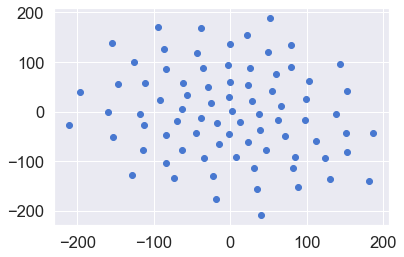

In [75]:
RS = 20150101
latent = latent.reshape((len(latent), -1))
proj = TSNE(random_state=RS).fit_transform(latent)
plt.scatter(proj[:,0], proj[:,1]) # some real clustering going on here

In [ ]:
# attention visualization???